In [1]:
from pydap.client import open_url
from datetime import datetime
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import pyproj
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import math
import pickle
from datetime import date
import os
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def plot_wind(df, var1, var2 ,interpolated = False):

    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.gridlines(draw_labels=True, alpha=0.5)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(np.sqrt(df[var1]**2 + df[var2]**2)), cmap='RdBu')
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    bar.ax.set_title('m/s')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if interpolated:
        plt.savefig('wind_speed_inter.png')
    else:
        plt.savefig('wind_speed.png')
    plt.show()
    
def plot_var(df, var):

    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(df[var]), cmap='RdBu')
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    bar.ax.set_title('db')
    plt.title(var)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('nbrcs-diff.svg')
    plt.show()
    
def generate_url(year, month, day, satellite_number):

    day_of_year = datetime(year, month, day).timetuple().tm_yday
    date_string = str(year) + str(month).zfill(2) + str(day).zfill(2)

    base_url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/cygnss/L1/v3.0/'
    specific_url = str(year) + '/' + str(day_of_year).zfill(3) + '/cyg0' + str(satellite_number) + '.ddmi.s' + \
                   date_string + '-000000-e' + date_string + '-235959.l1.power-brcs.a30.d31.nc'
    data_url = base_url + specific_url
    clickable_url = base_url + specific_url + '.html'

    return data_url + '?sp_lat,sp_lon,track_id,quality_flags,ddm_timestamp_utc,ddm_nbrcs,fresnel_coeff,sp_inc_angle', clickable_url

def fetch_cygnss(y1, m1, d1, y2, m2, d2):
    sdate = date(y1, m1, d1)   # start date
    edate = date(y2, m2, d2)   # end date
    delta = edate - sdate       # as timedelta
    df_list = []
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        df_list.append(get_cygnss_data(day.year, day.month, day.day))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)
    
def hours_since_ref(year, month, day):
    d0 = date(1992, 10, 5)
    d1 = date(year, month, day)
    delta = d1 - d0
    hours = delta.days*24
    return hours

def get_cygnss_data(year, month, day):
    cygnss_df = pd.DataFrame()
    hours = hours_since_ref(year, month, day)
    for sat_numb in range(1, 9): # Remember to change back to  1, 9
        print("Satellite number : " + str(sat_numb))
        test_data_url, test_clickable_url = generate_url(year, month, day, sat_numb)
        dataset = open_url(test_data_url, output_grid=False)
        for ddm in range(4):  # Remember to change back to 4
            ddm_df = pd.DataFrame()    
            print("ddm : " + str(ddm))
            
            ddm_timestamp_utc = np.array(dataset.ddm_timestamp_utc[:, ddm])
            
            # MAYBE REMOVE np.rint() which would give continous hours and better estimations?
            ddm_timestamp_utc = np.rint(ddm_timestamp_utc/3600) + hours
            
            ddm_df['sp_lat'] = np.array(dataset.sp_lat[:, ddm]).tolist()
            ddm_df['sp_lon'] = np.array(dataset.sp_lon[:, ddm]).tolist()
            ddm_df['hours_since_ref'] = ddm_timestamp_utc.tolist()
            ddm_df['ddm_nbrcs'] = np.array(dataset.ddm_nbrcs[:, ddm]).tolist()
            ddm_df['fresnel_coeff'] = np.array(dataset.fresnel_coeff[:, ddm]).tolist()
            ddm_df['sp_inc_angle'] = np.array(dataset.sp_inc_angle[:, ddm]).tolist()
            ddm_df['quality_flags'] = np.array(dataset.quality_flags[:, ddm]).tolist()

            
            '''
            track_id = np.array(dataset.track_id[:, ddm])
            ddm_df['ddm_channel'] = np.zeros(len(sp_lon))
            ddm_df = ddm_df.assign(ddm_channel=ddm)
            ddm_df['track_id'] = track_id.tolist()            
            # ODD quality flagg means bad data, so should be dropped
            
            '''

            for col in ddm_df.columns:
                if col != 'ddm_channel' and col != 'hours_since_ref':
                    ddm_df[col] = ddm_df[col].apply(lambda x: x[0])
            cygnss_df = cygnss_df.append(ddm_df, ignore_index=True)
    return cygnss_df

def open_oskar_data_local(filename):
    ds = xr.open_dataset(filename)
    oskar_df = ds.to_dataframe()
    oskar_df.dropna(inplace = True)
    oskar_df = oskar_df.reset_index()
    d0 = date(1992, 10, 5)
    d1 = oskar_df['time'][1].date()
    delta = d1 - d0
    hours = delta.days*24
    oskar_df['time'] = np.zeros(len(oskar_df['time']))
    oskar_df = oskar_df.assign(time=hours)
    oskar_df = oskar_df.rename(columns={"latitude": "sp_lat", "longitude": "sp_lon", "time" : "hours_since_ref"})
    oskar_df = oskar_df.loc[oskar_df['sp_lon'] < 380 ]
    oskar_df['sp_lon'] = oskar_df['sp_lon']%360
    oskar_df = reduce_area_of_df(oskar_df)
    return oskar_df

def fetch_all_oskar_files():
    df_list = []
    for filename in os.listdir('oskar_data'):
        df_list.append(open_oskar_data_local('oskar_data/' + filename))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)
    

In [2]:
# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 5]
    df = df[df.sp_lat >= -5]
    df = df[df.sp_lon >= 195]
    return df[df.sp_lon <= 215]

oskar_df = fetch_all_oskar_files()
oskar_df

hours_since_ref  sp_lat      sp_lon  depth         u         v
134830           253992     5.0  195.000000   15.0 -0.028628  0.133076
134831           253992     5.0  195.333333   15.0 -0.046934  0.099014
134832           253992     5.0  195.666667   15.0 -0.090535  0.080036
134833           253992     5.0  196.000000   15.0 -0.134513  0.085679
134834           253992     5.0  196.333333   15.0 -0.162957  0.069181
...                 ...     ...         ...    ...       ...       ...
160543           254232    -5.0  213.666667   15.0 -0.679626 -0.087167
160544           254232    -5.0  214.000000   15.0 -0.706045 -0.068990
160545           254232    -5.0  214.333333   15.0 -0.715096 -0.094679
160546           254232    -5.0  214.666667   15.0 -0.707012 -0.091616
160547           254232    -5.0  215.000000   15.0 -0.677701 -0.083790

[5667 rows x 6 columns]

In [3]:
read = True
if read:
    cygnss_df = pd.read_pickle('df.pkl')
else:
    cygnss_df = fetch_cygnss(2021, 10, 1, 2021, 10, 1)
    cygnss_df.to_pickle('df.pkl')

cygnss_df

sp_lat      sp_lon  hours_since_ref    ddm_nbrcs  fresnel_coeff  \
0       -16.354046  347.556946         254112.0    27.587561       0.683440   
1       -16.338102  347.580353         254112.0    27.114931       0.683447   
2       -16.322159  347.603729         254112.0    27.290983       0.683454   
3       -16.306217  347.627136         254112.0    26.335760       0.683461   
4       -16.290274  347.650513         254112.0    26.723040       0.683468   
...            ...         ...              ...          ...            ...   
5512627  28.005102   65.349808         254136.0 -9999.000000       0.654564   
5512628  28.011261   65.379822         254136.0 -9999.000000       0.654573   
5512629  28.017397   65.409851         254136.0 -9999.000000       0.654581   
5512630  28.023512   65.439873         254136.0 -9999.000000       0.654590   
5512631  28.029606   65.469902         254136.0 -9999.000000       0.654599   

         sp_inc_angle  quality_flags  
0           28.428041          65537  
1           28.418032          65537  
2           28.408052          65537  
3           28.398088          65537  
4           28.388163          65537  
...               ...            ...  
5512627     53.053688         269313  
5512628     53.048660         269313  
5512629     53.043629         269313  
5512630     53.038605         269313  
5512631     53.033569         269313  

[5512632 rows x 7 columns]

In [4]:
np.warnings.filterwarnings('ignore')
for key in cygnss_df:
    cygnss_df = cygnss_df[cygnss_df[key] != -9999.0]
cygnss_df = cygnss_df[cygnss_df.quality_flags%2 == 0]
cygnss_df.dropna(inplace = True)
cygnss_df['nbrcs_log'] = 10*np.log10(cygnss_df.ddm_nbrcs.to_numpy())
cygnss_df.drop('ddm_nbrcs', inplace=True, axis=1)
cygnss_df = reduce_area_of_df(cygnss_df)

cygnss_df

sp_lat      sp_lon  hours_since_ref  fresnel_coeff  sp_inc_angle  \
68566   -2.933609  202.195221         254122.0       0.585046     67.940628   
68567   -2.917802  202.218216         254122.0       0.585061     67.938751   
68568   -2.902014  202.241211         254122.0       0.585075     67.936897   
68569   -2.886207  202.264191         254122.0       0.585089     67.935020   
68570   -2.870396  202.287170         254122.0       0.585103     67.933159   
...           ...         ...              ...            ...           ...   
5420351 -2.843755  197.454742         254123.0       0.653302     54.952324   
5420353 -2.814036  197.499191         254123.0       0.653207     54.984695   
5420354 -2.799192  197.521408         254123.0       0.653159     55.000877   
5420355 -2.784325  197.543625         254123.0       0.653108     55.017094   
5420356 -2.769476  197.565842         254123.0       0.653056     55.033302   

         quality_flags  nbrcs_log  
68566          1048576  12.997142  
68567                0  13.760593  
68568                0  14.518236  
68569          1048576  14.761988  
68570                0  14.651203  
...                ...        ...  
5420351              0  17.782809  
5420353        1048576  17.043684  
5420354        1048576  15.066208  
5420355        1048576  17.252776  
5420356        1048576  15.773247  

[17242 rows x 7 columns]

In [5]:
#ds = xr.open_dataset('adaptor.mars.internal-1636460051.1656115-15503-16-d4e7e8a4-eb23-4930-9ae5-def374c3fe95.nc')
ds = xr.open_dataset('hele_verden_1_okt.nc')
era_5_df = ds.to_dataframe()
index_long = era_5_df.index.levels[0]
index_lat = era_5_df.index.levels[1]
index_time = era_5_df.index.levels[2]

start_time = pd.Timestamp(1992, 10, 5)
index_time_fixed = []
for tid in index_time:
    hours = tid - start_time
    index_time_fixed.append(hours.days*24 + hours.seconds/3600)

long, lat, time = np.meshgrid(index_long, index_lat, index_time_fixed, indexing = 'ij')

long = long.flatten()
lat = lat.flatten()
time = time.flatten()

era_5_df = pd.DataFrame({'sp_lon': long, 'sp_lat' :lat, 'hours_since_ref': time, 'u10': era_5_df["u10"].to_numpy()
            ,'v10': era_5_df["v10"].to_numpy()})
era_5_df = reduce_area_of_df(era_5_df)
era_5_df

sp_lon  sp_lat  hours_since_ref       u10       v10
13505280   195.0     5.0         254112.0 -5.658705  4.450381
13505281   195.0     5.0         254113.0 -5.470415  4.143770
13505282   195.0     5.0         254114.0 -5.521508  3.950792
13505283   195.0     5.0         254115.0 -5.626534  3.794057
13505284   195.0     5.0         254116.0 -5.800632  3.687282
...          ...     ...              ...       ...       ...
14890579   215.0    -5.0         254131.0 -7.327770  1.554718
14890580   215.0    -5.0         254132.0 -7.205713  1.833901
14890581   215.0    -5.0         254133.0 -7.139480  1.961248
14890582   215.0    -5.0         254134.0 -7.569047  1.400923
14890583   215.0    -5.0         254135.0 -7.509438  1.473413

[79704 rows x 5 columns]

In [6]:
interp_u10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['u10'])
print("done")
interp_v10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['v10'])

done


In [7]:
lons_to_interpolate = cygnss_df["sp_lon"].to_numpy()
lats_to_interpolate = cygnss_df["sp_lat"].to_numpy()
times_to_interpolate = cygnss_df["hours_since_ref"].to_numpy()

u10 = interp_u10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)
v10 = interp_v10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)

In [8]:
cygnss_and_interp_df = pd.DataFrame({'sp_lon': lons_to_interpolate, 'sp_lat' :lats_to_interpolate, 'hours_since_ref': times_to_interpolate, 'u10': u10, 'v10': v10, 'nbrcs_log' : cygnss_df['nbrcs_log'], 'fresnel_coeff' : cygnss_df['fresnel_coeff'], 'sp_inc_angle' : cygnss_df['sp_inc_angle']  })
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.194479  0.995905  12.997142   
68567    202.218216 -2.917802         254122.0 -8.190666  0.990826  13.760593   
68568    202.241211 -2.902014         254122.0 -8.186851  0.985750  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183685  0.982452  14.761988   
68570    202.287170 -2.870396         254122.0 -8.180920  0.980255  14.651203   
...             ...       ...              ...       ...       ...        ...   
5420351  197.454742 -2.843755         254123.0 -7.834143  1.422511  17.782809   
5420353  197.499191 -2.814036         254123.0 -7.795513  1.450863  17.043684   
5420354  197.521408 -2.799192         254123.0 -7.775401  1.465535  15.066208   
5420355  197.543625 -2.784325         254123.0 -7.760559  1.479029  17.252776   
5420356  197.565842 -2.769476         254123.0 -7.761596  1.488928  15.773247   

         fresnel_coeff  sp_inc_angle  
68566         0.585046     67.940628  
68567         0.585061     67.938751  
68568         0.585075     67.936897  
68569         0.585089     67.935020  
68570         0.585103     67.933159  
...                ...           ...  
5420351       0.653302     54.952324  
5420353       0.653207     54.984695  
5420354       0.653159     55.000877  
5420355       0.653108     55.017094  
5420356       0.653056     55.033302  

[17242 rows x 8 columns]

In [9]:
interp_u = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['u'])
print("done")
interp_v = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['v'])

done


In [10]:
lons_to_interpolate = cygnss_df["sp_lon"].to_numpy()
lats_to_interpolate = cygnss_df["sp_lat"].to_numpy()
times_to_interpolate = cygnss_df["hours_since_ref"].to_numpy()

u_current = interp_u(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)
v_current = interp_v(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)

cygnss_and_interp_df['u'] = u_current
cygnss_and_interp_df['v'] = v_current
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.194479  0.995905  12.997142   
68567    202.218216 -2.917802         254122.0 -8.190666  0.990826  13.760593   
68568    202.241211 -2.902014         254122.0 -8.186851  0.985750  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183685  0.982452  14.761988   
68570    202.287170 -2.870396         254122.0 -8.180920  0.980255  14.651203   
...             ...       ...              ...       ...       ...        ...   
5420351  197.454742 -2.843755         254123.0 -7.834143  1.422511  17.782809   
5420353  197.499191 -2.814036         254123.0 -7.795513  1.450863  17.043684   
5420354  197.521408 -2.799192         254123.0 -7.775401  1.465535  15.066208   
5420355  197.543625 -2.784325         254123.0 -7.760559  1.479029  17.252776   
5420356  197.565842 -2.769476         254123.0 -7.761596  1.488928  15.773247   

         fresnel_coeff  sp_inc_angle         u         v  
68566         0.585046     67.940628 -0.368874 -0.172019  
68567         0.585061     67.938751 -0.368602 -0.167844  
68568         0.585075     67.936897 -0.368329 -0.163669  
68569         0.585089     67.935020 -0.368057 -0.159497  
68570         0.585103     67.933159 -0.367785 -0.155325  
...                ...           ...       ...       ...  
5420351       0.653302     54.952324 -0.467231 -0.100043  
5420353       0.653207     54.984695 -0.472953 -0.094445  
5420354       0.653159     55.000877 -0.475812 -0.091648  
5420355       0.653108     55.017094 -0.478672 -0.088848  
5420356       0.653056     55.033302 -0.481532 -0.086051  

[17242 rows x 10 columns]

In [11]:
diff_u = cygnss_and_interp_df['u10']-cygnss_and_interp_df['u']
diff_v = cygnss_and_interp_df['v10']-cygnss_and_interp_df['v']
delta = np.sqrt(diff_u**2 + diff_v**2)

top_frac = 0.059*delta**3 - 0.147*delta**2 + 0.903**delta + 1.389
bot_frac = delta**3 + 18.161*delta**2 - 117.602*delta + 706.9
mss_from_wind_current = top_frac/bot_frac
fresnell_sqrd = cygnss_and_interp_df['fresnel_coeff'].to_numpy()**2

bias_df = pd.read_csv ('bias_model.csv')
interp_bias = LinearNDInterpolator(list(zip(bias_df['inc_angle'], bias_df['delta'])), bias_df['bias'])
biases = interp_bias(cygnss_and_interp_df['sp_inc_angle'], delta)
predicted_nbrcs = 10*np.log10(fresnell_sqrd/mss_from_wind_current) + biases

mss_from_cygnss = fresnell_sqrd/(10**((cygnss_and_interp_df['nbrcs_log'] - biases)/10))

In [12]:
# CYGNSS - CURRENT AND WIND ESTIMATIONS
cygnss_and_interp_df['diff_nbrcs'] = cygnss_and_interp_df['nbrcs_log'] - predicted_nbrcs
cygnss_and_interp_df['diff_mss'] = mss_from_cygnss - mss_from_wind_current
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.194479  0.995905  12.997142   
68567    202.218216 -2.917802         254122.0 -8.190666  0.990826  13.760593   
68568    202.241211 -2.902014         254122.0 -8.186851  0.985750  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183685  0.982452  14.761988   
68570    202.287170 -2.870396         254122.0 -8.180920  0.980255  14.651203   
...             ...       ...              ...       ...       ...        ...   
5420351  197.454742 -2.843755         254123.0 -7.834143  1.422511  17.782809   
5420353  197.499191 -2.814036         254123.0 -7.795513  1.450863  17.043684   
5420354  197.521408 -2.799192         254123.0 -7.775401  1.465535  15.066208   
5420355  197.543625 -2.784325         254123.0 -7.760559  1.479029  17.252776   
5420356  197.565842 -2.769476         254123.0 -7.761596  1.488928  15.773247   

         fresnel_coeff  sp_inc_angle         u         v  diff_nbrcs  diff_mss  
68566         0.585046     67.940628 -0.368874 -0.172019   -1.076396  0.004364  
68567         0.585061     67.938751 -0.368602 -0.167844   -0.317185  0.001175  
68568         0.585075     67.936897 -0.368329 -0.163669    0.436223 -0.001481  
68569         0.585089     67.935020 -0.368057 -0.159497    0.676488 -0.002234  
68570         0.585103     67.933159 -0.367785 -0.155325    0.562682 -0.001881  
...                ...           ...       ...       ...         ...       ...  
5420351       0.653302     54.952324 -0.467231 -0.100043    3.072450 -0.007414  
5420353       0.653207     54.984695 -0.472953 -0.094445    2.303494 -0.005981  
5420354       0.653159     55.000877 -0.475812 -0.091648    0.310400 -0.000999  
5420355       0.653108     55.017094 -0.478672 -0.088848    2.483806 -0.006292  
5420356       0.653056     55.033302 -0.481532 -0.086051    1.003112 -0.002979  

[17242 rows x 12 columns]

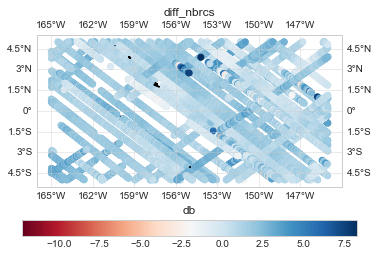

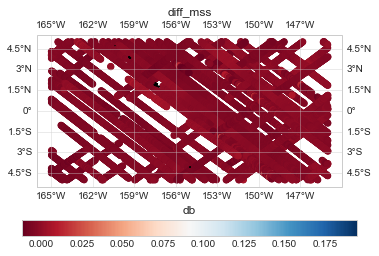

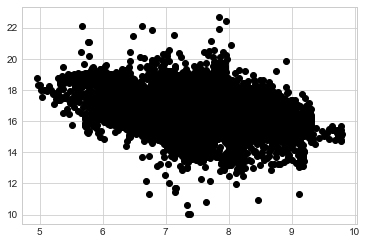

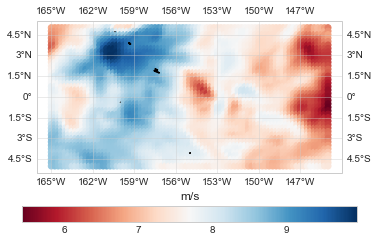

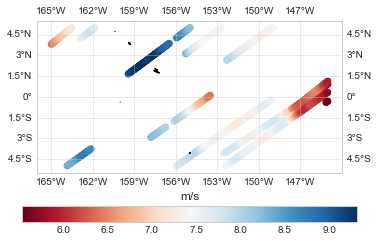

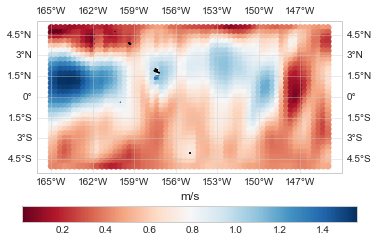

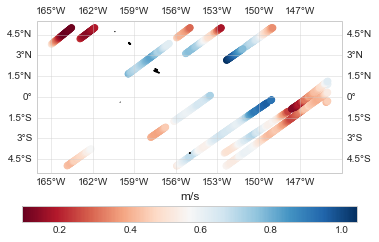

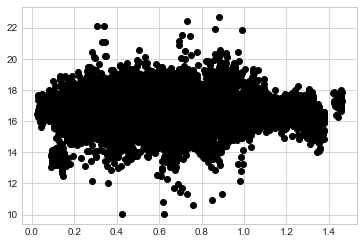

In [14]:
if True:
    plot_var(cygnss_and_interp_df,'diff_nbrcs' )
    plot_var(cygnss_and_interp_df,'diff_mss' )
    plot_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_interp_df['nbrcs_log'], 'Wind_Speed' : np.sqrt(cygnss_and_interp_df['u10']**2+cygnss_and_interp_df['v10']**2)})
    plot_df = plot_df[plot_df.NBRCS_LOG_SCALED > 10]
    plot_df = plot_df[plot_df.NBRCS_LOG_SCALED < 23]
    plot_df = plot_df[plot_df.Wind_Speed > 0.5]

    fig = px.density_heatmap(plot_df, y="NBRCS_LOG_SCALED", x="Wind_Speed", nbinsy=100 , color_continuous_scale=px.colors.sequential.Blackbody  ,title="2D Histogram plot of Wind speed and NBRCS in DB scale")

    fig.show()

    plt.style.use('seaborn-whitegrid')
    plt.plot((plot_df['Wind_Speed'].to_numpy()), (plot_df['NBRCS_LOG_SCALED'].to_numpy()), 'o', color='black');
    
    plt.show()

    era_5_df_one_hour = era_5_df.loc[(era_5_df['hours_since_ref'] == 254122.0)]
    cygnss_and_wind_df_one_hour = cygnss_and_interp_df.loc[(cygnss_and_interp_df['hours_since_ref'] == 254122.0)]

    plot_wind(era_5_df_one_hour, 'u10', 'v10')
    plot_wind(cygnss_and_wind_df_one_hour,  'u10', 'v10',interpolated= True)
    
    oskar_df_one_hour = oskar_df.loc[(oskar_df['hours_since_ref'] == 254112)]
    cygnss_and_wind_df_one_hour = cygnss_and_interp_df.loc[(cygnss_and_interp_df['hours_since_ref'] == 254122.0)]

    plot_wind(oskar_df_one_hour, 'u', 'v')
    plot_wind(cygnss_and_wind_df_one_hour,  'u', 'v', interpolated= True)

    plot_current_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_interp_df['nbrcs_log'], 'Ocean_current_speed_15_meters_depth' : np.sqrt(cygnss_and_interp_df['u']**2+cygnss_and_interp_df['v']**2)})
    plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED > 10]
    plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED < 23]
    #plot_current_df = plot_current_df[plot_current_df.Ocean_current_speed_15_meters_depth < 1.1]
    fig = px.density_heatmap(plot_current_df, y="NBRCS_LOG_SCALED", x="Ocean_current_speed_15_meters_depth", title="2D Histogram plot of Ocean current strength at 15 meters depth and NBRCS in DB scale", color_continuous_scale=px.colors.sequential.Blackbody)
    fig.show()

    plt.style.use('seaborn-whitegrid')
    plt.plot((plot_current_df['Ocean_current_speed_15_meters_depth'].to_numpy()), (plot_current_df['NBRCS_LOG_SCALED'].to_numpy()), 'o', color='black');
    
    plt.show()
    cygnss_and_wind_df_one_hour['total_wind'] = np.sqrt(cygnss_and_wind_df_one_hour['u10']**2 + cygnss_and_wind_df_one_hour['v10']**2)

    fig = px.density_mapbox(cygnss_and_wind_df_one_hour, lat='sp_lat', lon='sp_lon', z='total_wind', radius=10,
                            center=dict(lat=0, lon=180), zoom=0,
                            mapbox_style="stamen-terrain")
    fig.show()
